# Create a climatology with different data source
In this notebook we create a climatology for the region of interest, using observations from the Beacon services.
Once data are downloaded, a duplicate removal is applied.
Finally, the gridded fields are created with DIVAnd software tool.

In [ ]:
using HTTP
using Dates
using NCDatasets
using Colors
using Makie
using CairoMakie
using GeoMakie
using DIVAnd
using Random
using Downloads
using JupyterFormatter
include("./DIVAndFairEase.jl")
enable_autoformat()

<div class="alert alert-block alert-info">
Here the API token is stored as an environment variable.
It is also possible to store it in a local file. 
</div>

In [3]:
token = ENV["beaconAPItoken"];

## 🪛 Configuration
Set the region and the variable of interest.   
The variable `datasourcelist` contains the `Beacon` instances that will be used for the data queries.

In [4]:
regionname = "North_Adriatic"
varname = "sea_water_temperature"
varname = "sea_water_salinity"
doplot = true

datasourcelist = [
    "Euro-Argo",
    "CORA Profile",
    "CORA Timeseries",
    "World Ocean Database",
    "SeaDataNet CDI TS",
];

5-element Vector{String}:
 "Euro-Argo"
 "CORA Profile"
 "CORA Timeseries"
 "World Ocean Database"
 "SeaDataNet CDI TS"

In [38]:
### 📁📁 Create directories

In [5]:
datadir = joinpath("../data/", regionname)
outputdir = joinpath("../output/", regionname)
figdir = joinpath("../figures/", regionname)
mkpath.([datadir, outputdir, figdir]);

### 🗺️ Spatial extent
The bounding box is set according to the region name.

In [6]:
domaininfo = Dict(
    "North_Adriatic" => [12.0, 18.0, 43.0, 46.0],
    "Arctic_region" => [-44.25, 70.0, 56.5, 83.0],
    "North_East_Atlantic" => [-42.0, -0.1, 24.9, 48.0],
    "Baltic_Sea" => [9.4, 30.9, 53.0, 65.9],
    "Black_Sea" => [26.5, 41.95, 40.0, 47.95],
    "Mediterranean_Sea" => [-7.0, 36.375, 30.0, 45.875],
    "North_Sea" => [-100.0, 50.0, -80.0, 80.0],
    "Canary_Islands" => [-20.0, -9.0, 25.0, 31.5],
    "World_Ocean" => [-180.0, 180.0, -90.0, 90.0],
);

### 📆 Depth and time ranges

In [7]:
mindepth = 0.0 #Minimum water depth
maxdepth = 1000.0 #Maximum water depth
datestart = DateTime(1960, 1, 1)
dateend = DateTime(2024, 12, 31)

2024-12-31T00:00:00

### 🌡️ Variable units

In [8]:
variableunits = Dict(
    "sea_water_temperature" => "degree_Celsius",
    "sea_water_salinity" => "psu",
    "mass_concentration_of_chlorophyll_a_in_sea_water" => "mg/m3",
    "moles_of_nitrate_per_unit_mass_in_sea_water" => "micromole/kg",
);

## Data query
Different data queries will be performed to get the observations in the selected region.
### 🧑‍⚕️ Health check [optional]
One can check of the `Beacon` instances are up and running.

In [9]:
for datasource in datasourcelist
    r = HTTP.get(
        joinpath(DIVAndFairEase.beacon_services[datasource], "api/health"),
        ["Authorization" => "Bearer $(token)"],
    )
    if r.status == 200
        @info("$(datasource) Beacon instance is working")
    else
        @warn("$(datasource) Beacon is down or not reachable.")
    end
end

[ Info: Euro-Argo Beacon instance is working
[ Info: CORA Profile Beacon instance is working
[ Info: CORA Timeseries Beacon instance is working
[ Info: World Ocean Database Beacon instance is working
[ Info: SeaDataNet CDI TS Beacon instance is working


### Prepare queries and download data
The observations are saved as netCDF files (one per data source),      
so that they can be later re-used.
<div class="alert alert-block alert-info">
It is also possible to get the data in other formats such as <code>Parquet</code>,  <code>ODV</code> or <code>Arrow IPC</code>.
</div>

In [10]:
minlon = domaininfo[regionname][1]
maxlon = domaininfo[regionname][2]
minlat = domaininfo[regionname][3]
maxlat = domaininfo[regionname][4]

outputfilelist = []
for datasource in datasourcelist

    @info("Working on $(datasource)")

    parameter1 = "TEMP"
    parameter1 = "PSAL"
    vmin = 0.0
    vmax = 40.0

    paramname = Dict(
        "World Ocean Database" => "Temperature",
        "EMODnet Chemistry" => "ITS_90_water_temperature",
        "SeaDataNet CDI TS" => "TEMPPR01",
        "Euro-Argo" => "TEMP",
        "CORA Profile" => "TEMP",
        "CORA Timeseries" => "TEMP",
    )

    paramname = Dict(
        "World Ocean Database" => "Salinity",
        "EMODnet Chemistry" => parameter1,
        "SeaDataNet CDI TS" => "PSAL",
        "Euro-Argo" => parameter1,
        "CORA Profile" => parameter1,
        "CORA Timeseries" => parameter1,
    )

    datasource_name = replace(datasource, " " => "-")

    # Build query
    query = DIVAndFairEase.prepare_query(
        datasource,
        paramname[datasource],
        Dates.Date(datestart),
        Dates.Date(dateend),
        mindepth,
        maxdepth,
        minlon,
        maxlon,
        minlat,
        maxlat,
        vmin = vmin,
        vmax = vmax,
    )

    # Construct file and figure names
    filename = joinpath(
        datadir,
        "$(regionname)_$(datasource_name)_$(varname)_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m.nc",
    )

    # Write the data in netCDF files
    @info("Data will be written in file:\n$(filename)")
    if isfile(filename)
        @info("File already downloaded")
    else
        @time open(filename, "w") do io
            r = HTTP.request(
                "POST",
                joinpath(DIVAndFairEase.beacon_services[datasource], "api/query"),
                [
                    "Content-type" => "application/json",
                    "Authorization" => "Bearer $(token)",
                ],
                query,
                response_stream = io,
            )
            @info(r.status)
        end

        NCDataset(filename, "a") do ds
            ds.attrib["data_source"] = datasource
            ds.attrib["date_created"] = Dates.format(Dates.now(), "yyyy-mm-ddTHH:MM:SS")
            # Maybe add other attributes
        end
    end
    @info("NetCDF file size: $(round(filesize(filename)/1000^2, digits=1))M")
    push!(outputfilelist, filename)

end

[ Info: Working on Euro-Argo
┌ Info: Data will be written in file:
└ ../data/North_Adriatic/North_Adriatic_Euro-Argo_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: File already downloaded
[ Info: NetCDF file size: 2.8M
[ Info: Working on CORA Profile
┌ Info: Data will be written in file:
└ ../data/North_Adriatic/North_Adriatic_CORA-Profile_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: File already downloaded
[ Info: NetCDF file size: 13.8M
[ Info: Working on CORA Timeseries
┌ Info: Data will be written in file:
└ ../data/North_Adriatic/North_Adriatic_CORA-Timeseries_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: File already downloaded
[ Info: NetCDF file size: 15.0M
[ Info: Working on World Ocean Database
┌ Info: Data will be written in file:
└ ../data/North_Adriatic/North_Adriatic_World-Ocean-Database_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: File already downloaded
[ Info: NetCDF file size: 53.7M
[ Info: Working on SeaDataNet CDI TS
┌ Info: 

 71.308159 seconds (260.71 k allocations: 13.489 MiB, 2 lock conflicts, 0.42% compilation time)


[ Info: NetCDF file size: 0.0M


## 🗺️ General observation maps
### All the data source together

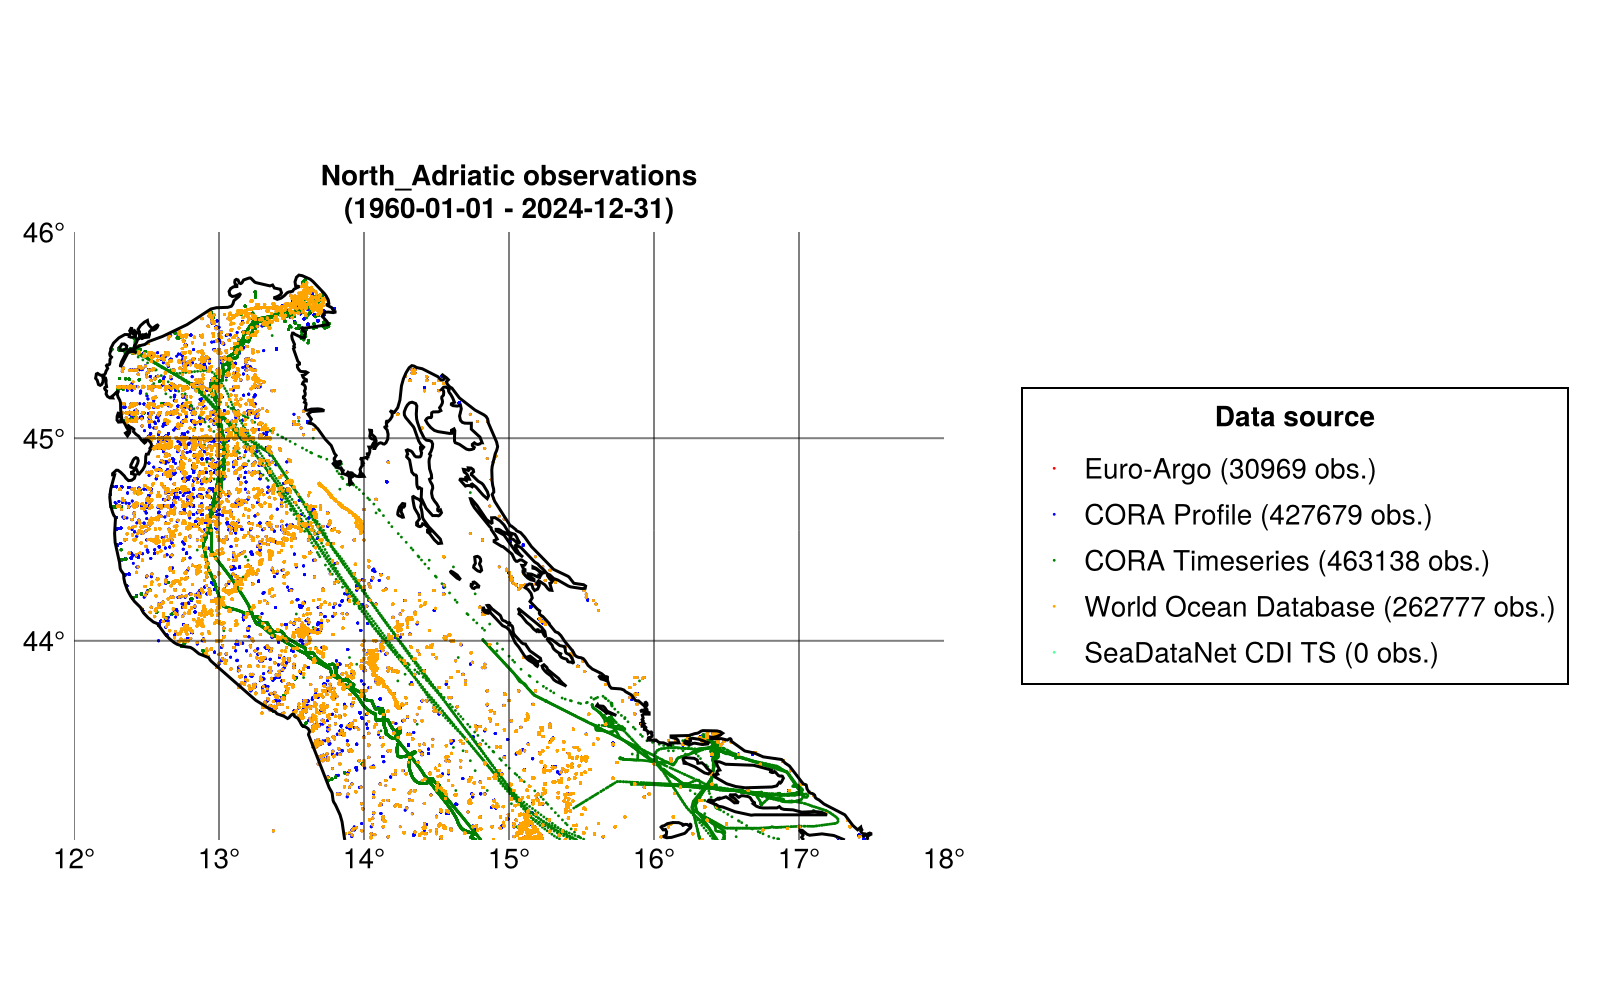

In [11]:
if doplot
    if length(outputfilelist) > 0
        colorlist = [:red, :blue, :green, :orange, :seagreen1, :aqua, :magenta]

        fig = Figure(size = (800, 500))
        ga = GeoAxis(
            fig[1, 1];
            dest = "+proj=merc",
            title = "$(regionname) observations\n($(Dates.Date(datestart)) - $(Dates.Date(dateend)))",
        )

        for (iii, outputfile) in enumerate(outputfilelist)
            NCDataset(outputfile, "r") do ds
                datasource = ds.attrib["data_source"]
                lon = ds["LONGITUDE"][:]
                lat = ds["LATITUDE"][:]

                scatter!(
                    ga,
                    lon,
                    lat,
                    color = colorlist[iii],
                    markersize = 2,
                    label = "$(datasource) ($(length(lon)) obs.)",
                )
            end

        end
        lines!(ga, GeoMakie.coastlines(10), color = :black)
        # poly!(ga, land, color=:grey)
        xlims!(ga, minlon, maxlon)
        ylims!(ga, minlat, maxlat)
        fig[1, 2] = Legend(fig, ga, "Data source")

        figname1 = joinpath(
            figdir,
            "$(regionname)_$(replace(varname, " "=>"_"))_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m.png",
        )
        Makie.save(figname1, fig)

        fig
    else
        @warn("No file has been written, hence no plot will be produced")
    end
end

### 🗺️ Subplot by data source 

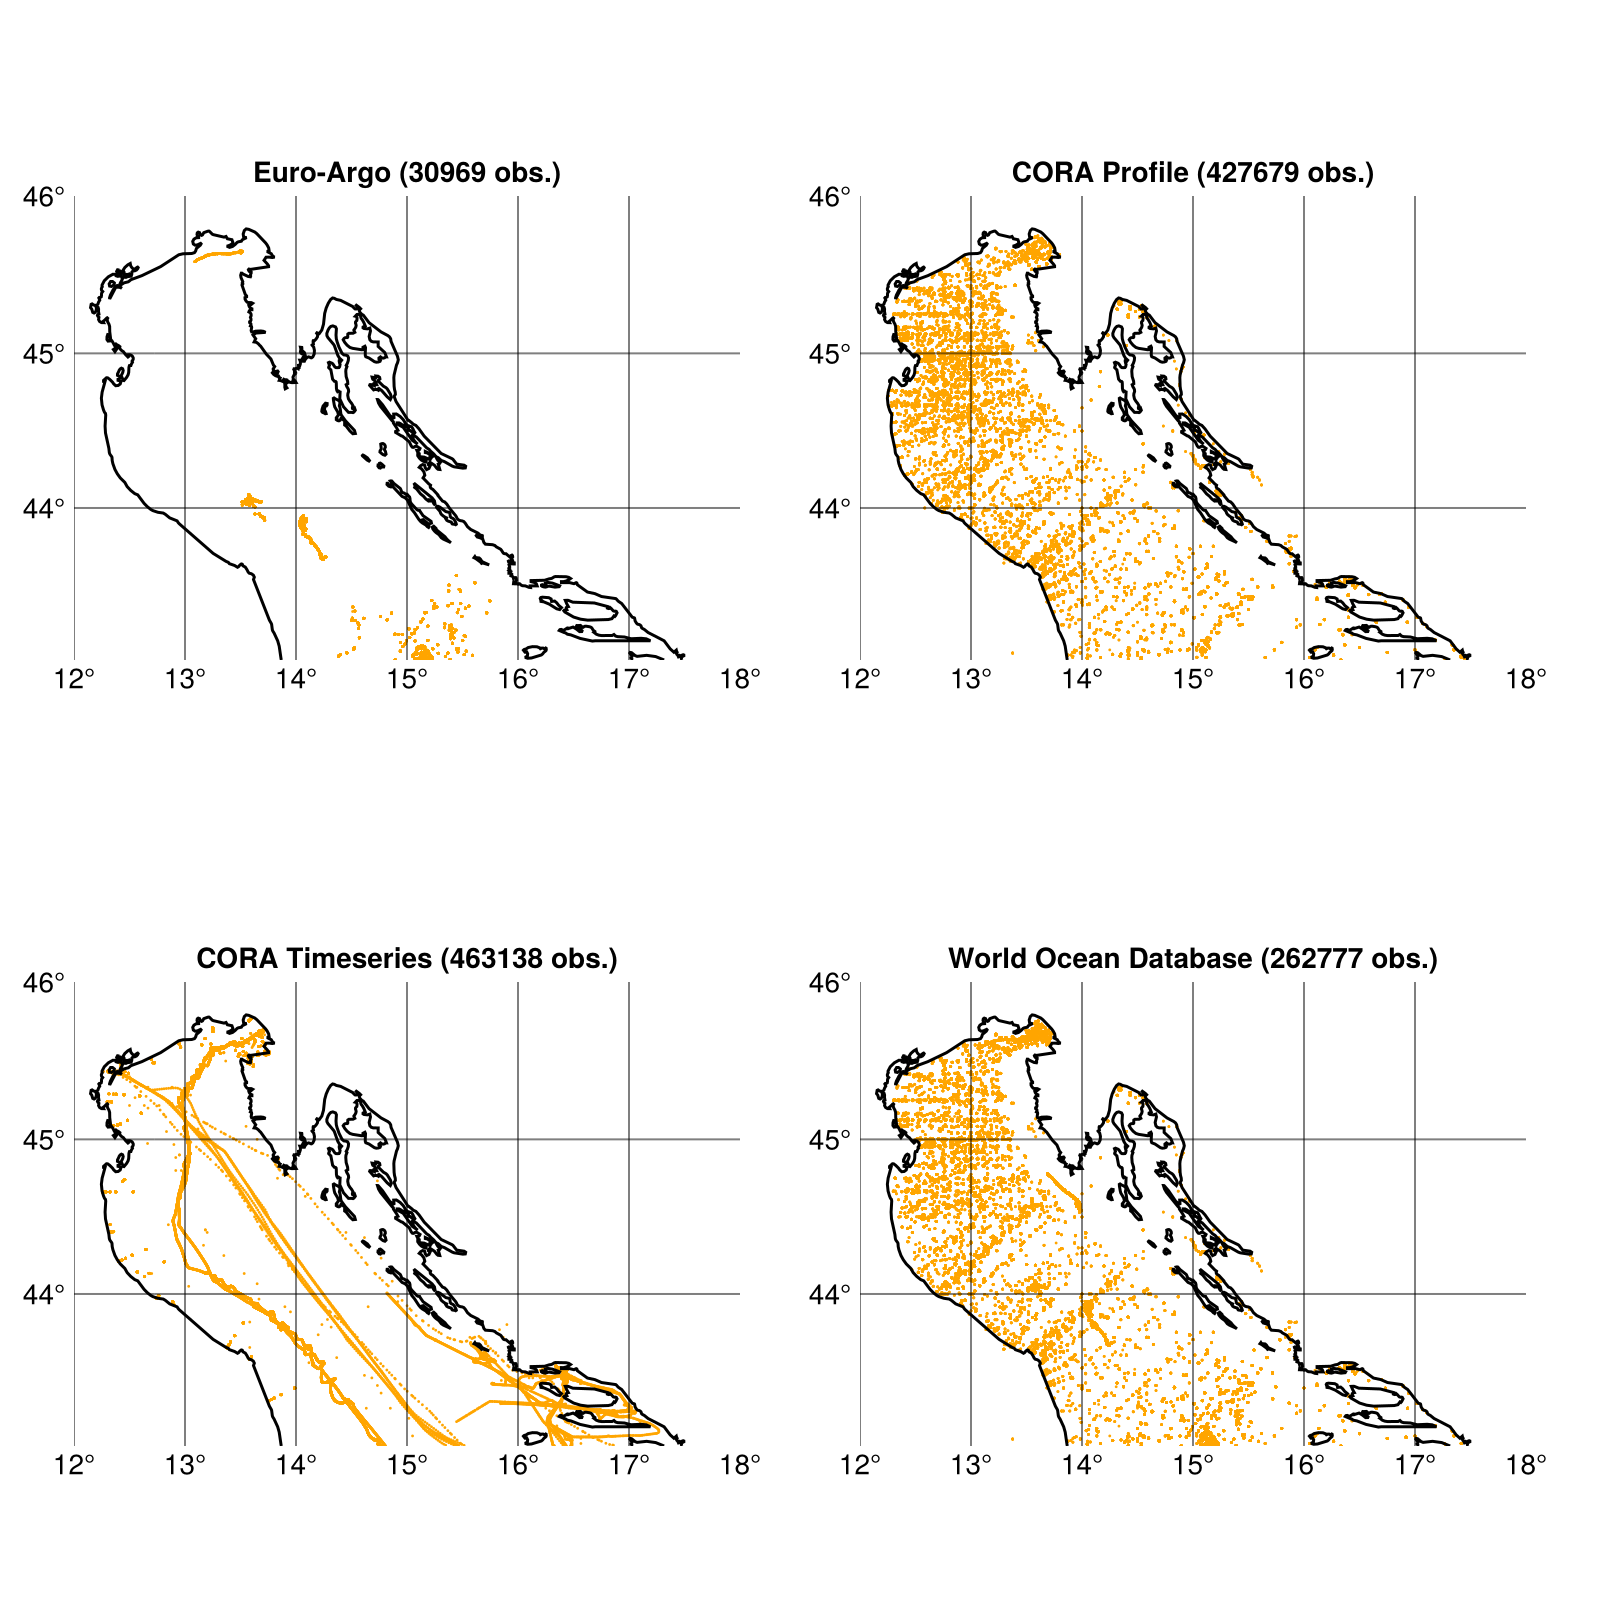

In [13]:
if doplot
    fig2 = Figure(size = (800, 800))

    for (iii, outputfile) in enumerate(outputfilelist[1:4])
        NCDataset(outputfile, "r") do ds
            datasource = ds.attrib["data_source"]
            lon = ds["LONGITUDE"][:]
            lat = ds["LATITUDE"][:]
            ga = GeoAxis(
                fig2[1+(iii-1)÷2, 1+(iii-1)%2];
                dest = "+proj=merc",
                title = "$(datasource) ($(length(lon)) obs.)",
            )
            plot!(ga, lon, lat, color = :orange, markersize = 2)
            lines!(ga, GeoMakie.coastlines(10), color = :black)
            # poly!(ga, land, color=:grey)
            xlims!(ga, minlon, maxlon)
            ylims!(ga, minlat, maxlat)
        end

    end

    figname2 = joinpath(
        figdir,
        "$(regionname)_$(replace(varname, " "=>"_"))_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m_all.png",
    )
    save(figname2, fig2)
    fig2
end

### 📊 Value histograms
We check the quality of the data by displaying their values as histograms.

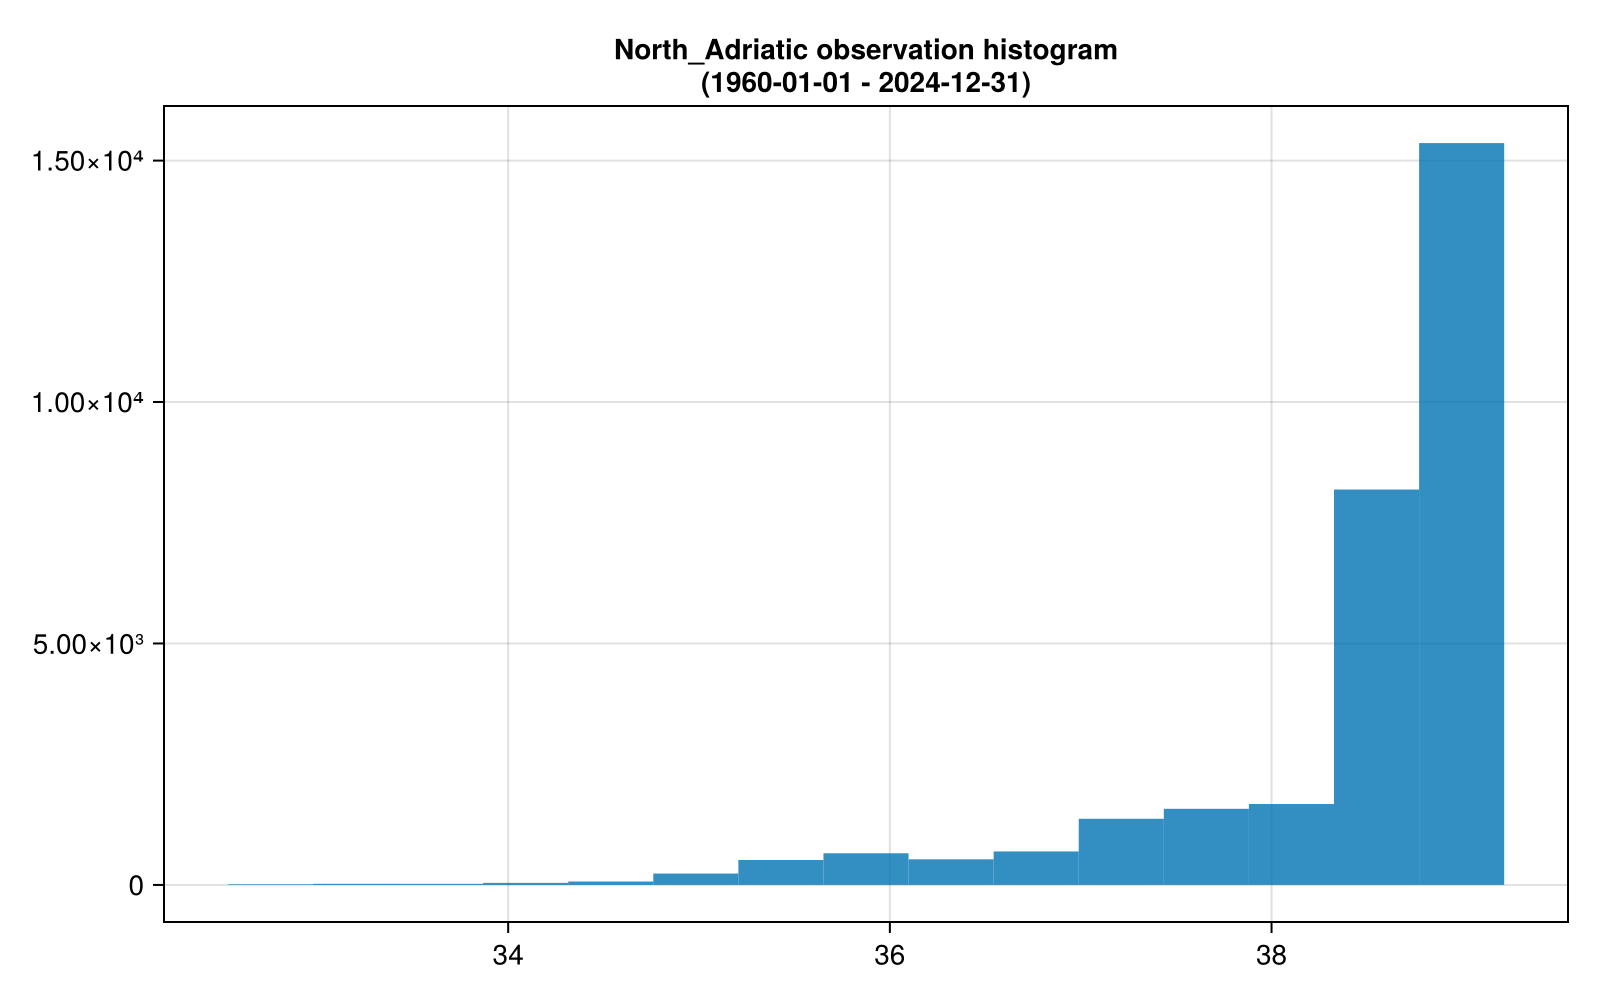

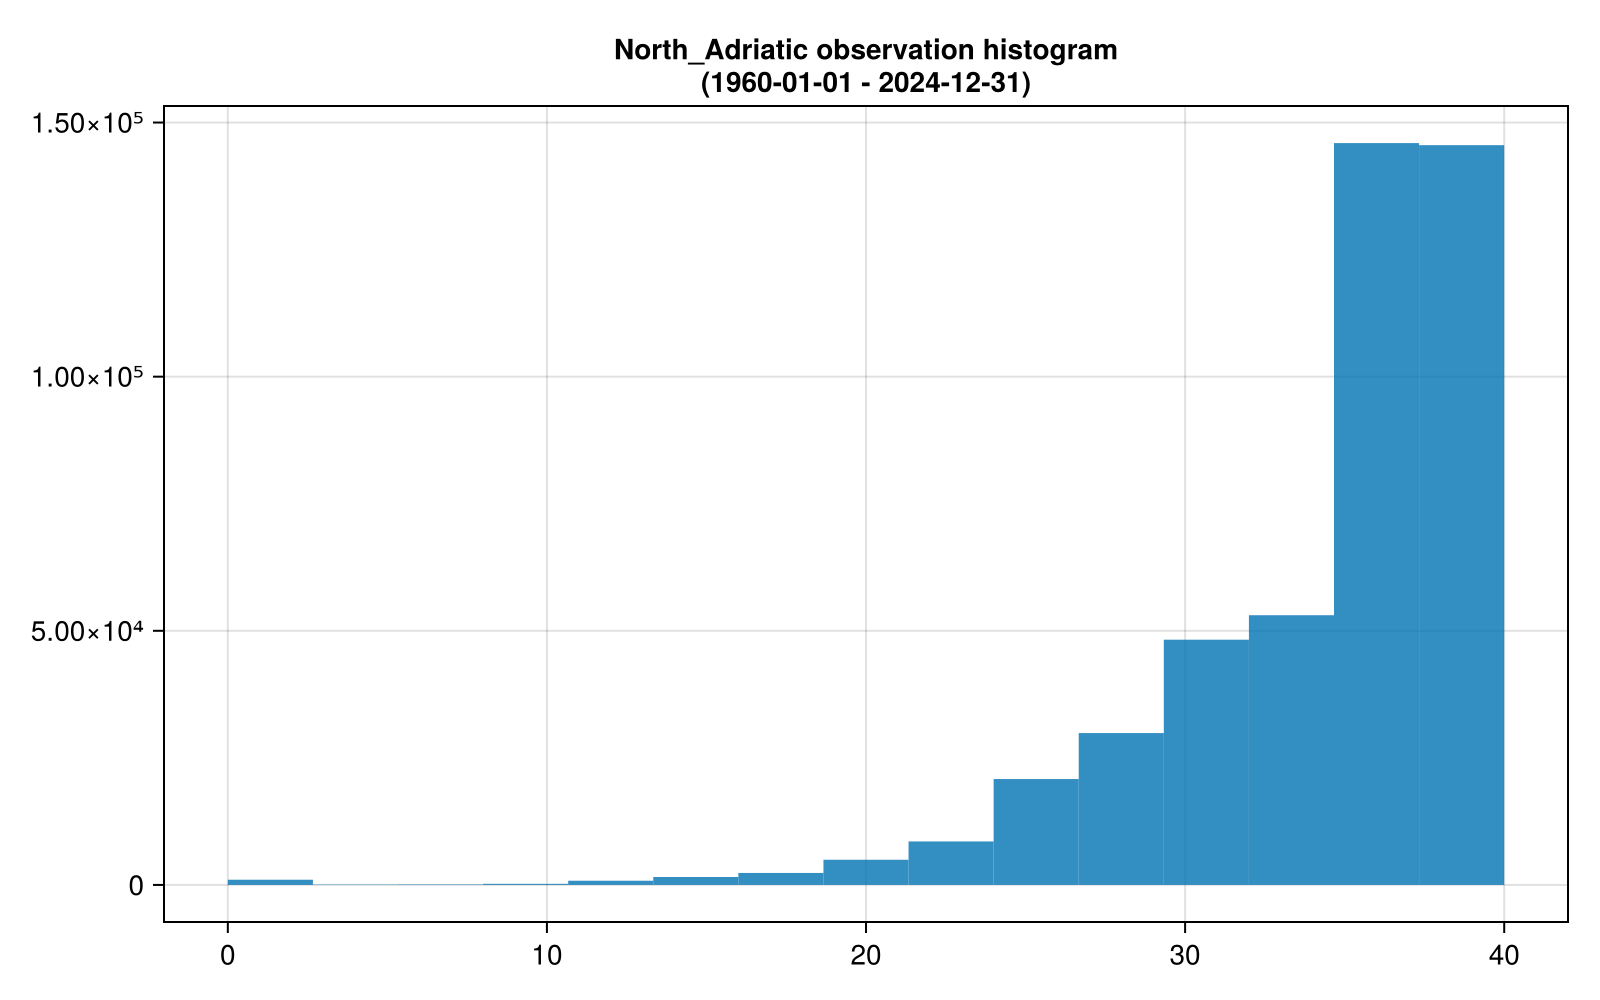

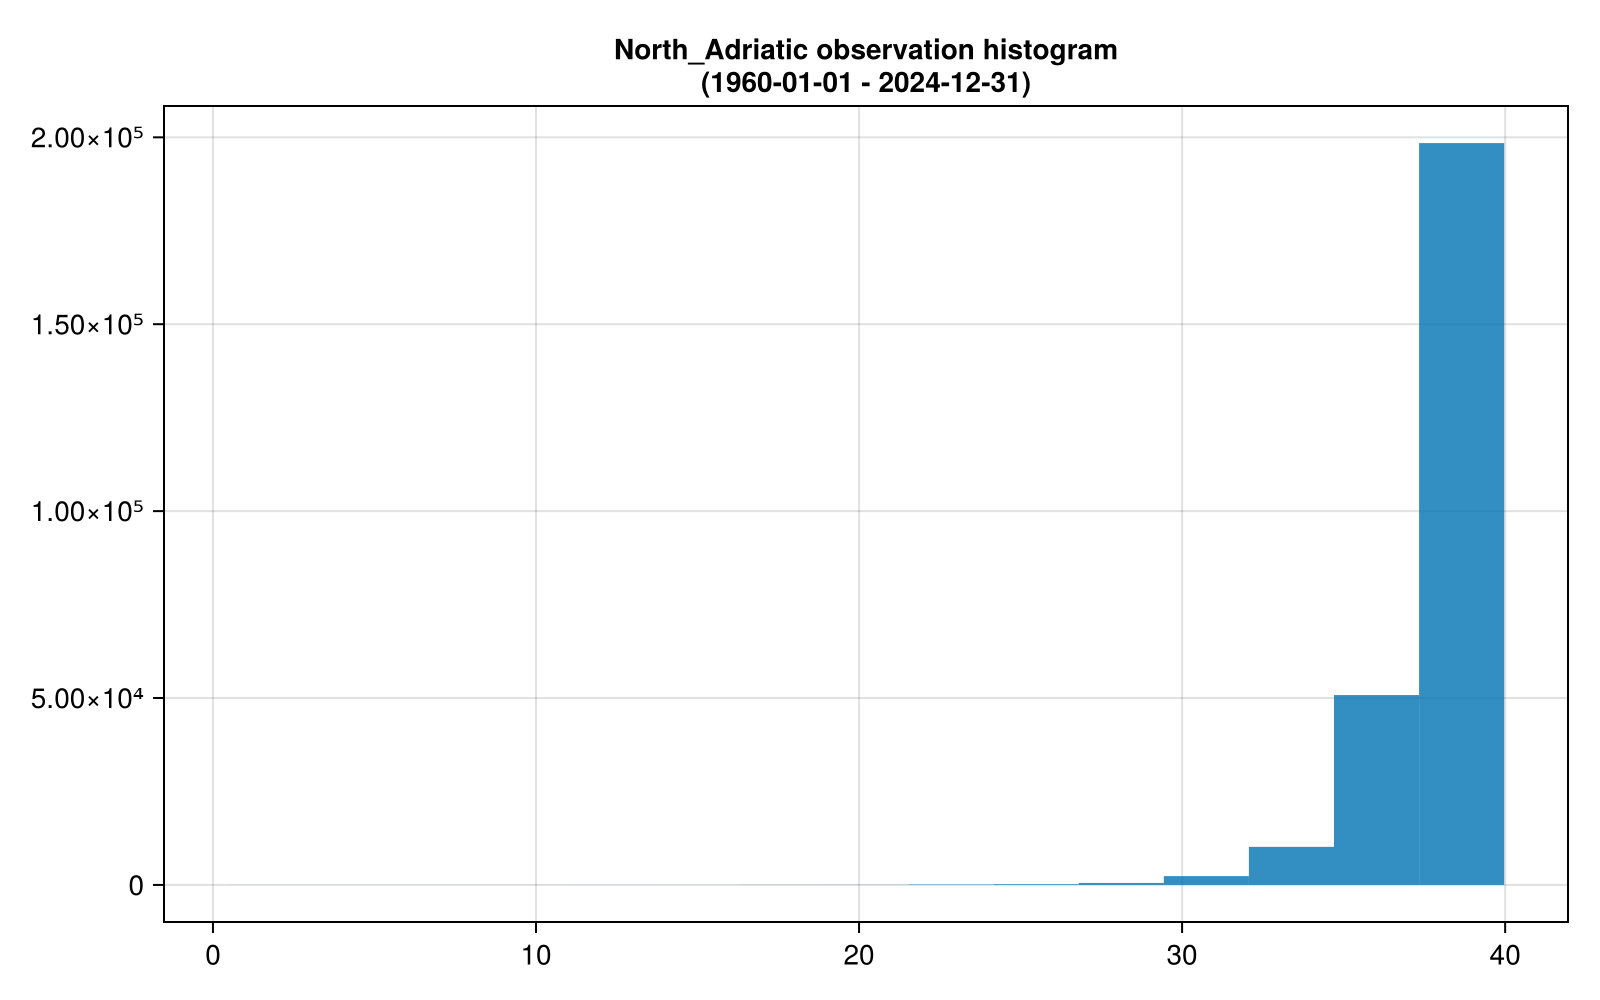

In [58]:
if true
    for (iii, outputfile) in enumerate(outputfilelist[1:4])
        NCDataset(outputfile, "r") do ds
            datasource = ds.attrib["data_source"]
            lon = ds["LONGITUDE"][:]
            lat = ds["LATITUDE"][:]
            obsvalues = coalesce.(ds[keys(ds)[1]][:], NaN)
            thevar = ds[keys(ds)[1]][:]
            goodvalues = findall(.!(ismissing.(thevar)))

            if typeof(thevar[goodvalues]) <: Vector{Union{Missing,String}}
                obsvalues = parse.(Float64, thevar[goodvalues])
            else
                obsvalues = thevar[goodvalues]
            end

            fig = Figure(size = (800, 500))
            ax = Axis(
                fig[1, 1],
                title = "$(regionname) observation histogram\n($(Dates.Date(datestart)) - $(Dates.Date(dateend)))",
            )
            hist!(ax, obsvalues)

            figname1 = joinpath(
                figdir,
                "histogram_$(regionname)_$(replace(varname, " "=>"_"))_$(datasource)_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m.png",
            )
            Makie.save(figname1, fig)
            display(fig)
        end
    end
end

## Duplicate removal
This a time-consuming yet essential step when building a climatology.   
### Set parameters
We define acceptable ranges for the separation between 2 data points:       
for instance if the longitute separation between these 2 points is larger than `Δlon`, then they are assumed not to be duplicates. 

<div class="alert alert-block alert-info">
The parameters for the duplicate removal have to be tuned: <br>
- if no outliers are detected, it can mean that the threshold defined for the distances are too large; <br>
- if too many outliers are found, it can mean that the thresholds defined are too small.
</div>

In [15]:
Δlon = 0.01
Δlat = 0.01
Δdepth = 0.05
Δtime = 0.0
Δvar = 0.01

0.01

We iterate over the data files that were downloaded

In [40]:
# Allocate vectors of vectors
nfiles = length(outputfilelist)
lonall = Vector{Vector{Float64}}(undef, nfiles)
latall = Vector{Vector{Float64}}(undef, nfiles)
timesall = Vector{Vector{DateTime}}(undef, nfiles)
depthall = Vector{Vector{Float64}}(undef, nfiles)
obsall = Vector{Vector{Float64}}(undef, nfiles)
obsidall = Vector{Vector{String}}(undef, nfiles)

for (iii, datafile) in enumerate(outputfilelist[1:4])
    @info("Working on file $(basename(datafile))")

    # Set the reference date (different for each dataset)
    dateref = Dates.DateTime(1950, 1, 1)
    if occursin("World_Ocean_Database", basename(datafile))
        dateref = Dates.DateTime(1770, 1, 1)
    elseif occursin("EMODnet Chemistry", basename(datafile))
        dateref = Dates.DateTime(1921, 1, 1)
    end

    NCDataset(datafile, "r") do ds

        # Get coordinates
        thevar = ds[keys(ds)[1]][:]
        goodvalues = findall(.!(ismissing.(thevar)))
        lonall[iii] = ds["LONGITUDE"][goodvalues]
        latall[iii] = ds["LATITUDE"][goodvalues]
        depthall[iii] = ds["DEPTH"][goodvalues]
        timesall[iii] = coalesce.(ds["datetime"][goodvalues], NaN)

        if typeof(thevar[goodvalues]) <: Vector{Union{Missing,String}}
            obsall[iii] = parse.(Float64, thevar[goodvalues])
        else
            obsall[iii] = thevar[goodvalues]
        end
    end
end

[ Info: Working on file North_Adriatic_Euro-Argo_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: Working on file North_Adriatic_CORA-Profile_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: Working on file North_Adriatic_CORA-Timeseries_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: Working on file North_Adriatic_World-Ocean-Database_sea_water_salinity_19600101-20241231_0-1000m.nc
[ Info: Working on file North_Adriatic_SeaDataNet-CDI-TS_sea_water_salinity_19600101-20241231_0-1000m.nc


### Remove duplicates

In [17]:
@time obslon, obslat, obsdepth, obstime, obsval, pct = DIVAndFairEase.merge_datasets2(
    lonall,
    latall,
    depthall,
    timesall,
    obsall,
    Δlon,
    Δlat,
    Δdepth,
    Δtime,
    Δvar,
);

[ Info: Working on dataset #2
[ Info: 30969
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Working on dataset #3
[ Info: 458648
[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: 0.0%
[ Info: Working on dataset #4
[ Info: 921786
[ Info: Number of possible duplicates: 80856
[ Info: Percentage of duplicates: 30.77%
[ Info: Working on dataset #5
[ Info: 1103707


 14.519275 seconds (8.49 M allocations: 7.587 GiB, 15.75% gc time, 2.76% compilation time)


[ Info: Number of possible duplicates: 0
[ Info: Percentage of duplicates: NaN%


#### 🗺️ Plot the observations after duplicate removal

In [60]:
if doplot
    fig = Figure(size = (800, 500))
    ga = GeoAxis(fig[1, 1]; dest = "+proj=merc", title = "$(regionname) observations")

    plot!(
        ga,
        obslon,
        obslat,
        color = :orange,
        markersize = 5,
        label = "$(length(obslon)) obs.",
    )
    lines!(ga, GeoMakie.coastlines(10), color = :black)
    xlims!(ga, minlon, maxlon)
    ylims!(ga, minlat, maxlat)
    fig[1, 2] = Legend(fig, ga, "Data source")

    figname = joinpath(
        figdir,
        "$(regionname)_$(replace(varname, " "=>"_"))_$(Dates.format(datestart, "yyyymmdd"))-$(Dates.format(dateend, "yyyymmdd"))_$(Int(mindepth))-$(Int(maxdepth))m_dupl.png",
    )
    save(figname, fig)
    display(fig)
end

CairoMakie.Screen{IMAGE}


### Generate (random) observations IDs
In a normal workflow, those IDs are read from the data files, but here some of the datasets as obtained from `Beacon` don't come with IDs.

In [62]:
obsid = [randstring(8) for ii = 1:length(obslon)];

### 💾 Save all the observations in a new netCDF file

In [64]:
outputfile = joinpath(outputdir, "$(regionname)_merged.nc")
isfile(outputfile) ? rm(outputfile) : @debug("ok")
DIVAnd.saveobs(outputfile, varname, obsval, (obslon, obslat, obsdepth, obstime), obsid)

NCDataset(outputfile, "a") do ds
    ds.attrib["data_source"] = datasourcelist
    ds.attrib["date_created"] = Dates.format(Dates.now(), "yyyy-mm-ddTHH:MM:SS")
    # Maybe add other attributes
end

"2025-06-10T14:55:39"

## DIVAnd interpolation
This is where the calculation takes place.      

### Set parameters
We have to define some parameters and options, like:
- the spatial resolution of the final grid
- the vertical (depth) levels
- the time periods over which the fields have to be computed.

<div class="alert alert-block alert-info">
For testing purposes, it is advised to start with a less fine grid resolution, then once everything is working, the final resolution can be selected. 
</div>

In [21]:
dx, dy = 0.02, 0.02
lonr = minlon:dx:maxlon
latr = minlat:dy:maxlat
timerange = [Date(1960, 1, 1), Date(2024, 12, 31)];

depthr = [
    0.0,
    5.0,
    10.0,
    15.0,
    20.0,
    25.0,
    30.0,
    40.0,
    50.0,
    60,
    70,
    80,
    90,
    100,
    125,
    150,
    175,
    200,
];

yearlist = [1960:2024];
monthlist = 1:12;

TS = DIVAnd.TimeSelectorYearListMonthList(yearlist, monthlist)
@info("$(length(TS)) time periods")

[ Info: 12 time periods


### Download the GEBCO bathymetry
If will be used for the generation of the land-sea mask.

In [22]:
datadir = "../data/"
bathfile = joinpath(datadir, "gebco_30sec_4.nc")
if isfile(bathfile)
    @info("Bathymetry already downloaded")
else
    Downloads.download(
        "https://dox.uliege.be/index.php/s/RSwm4HPHImdZoQP/download",
        bathfile,
    )
end

(12.0:0.02:18.0, 43.0:0.02:46.0, Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

#### Read the bathymetry and the mask
The mask is a 3D matrix (longitude, latitude, depth), since it has to take into account the level where the interpolation is performed.

In [42]:
bx, by, b = load_bath(bathfile, true, lonr, latr)
_, _, mask = load_mask(bathfile, true, lonr, latr, depthr)

(12.0:0.02:18.0, 43.0:0.02:46.0, Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

#### 🗺️ Plot the bathymetry

In [23]:
if doplot
    figbathy = GeoMakie.Figure()
    ga1 = GeoAxis(figbathy[1, 1]; dest = "+proj=merc", title = "GEBCO bathymetry")
    hm1 = heatmap!(
        ga1,
        bx,
        by,
        -b,
        interpolate = false,
        colorrange = (-400.0, 400),
        colormap = :delta,
    )
    xlims!(ga1, (bx[1], bx[end]))
    ylims!(ga1, (by[1], by[end]))
    contour!(ga1, bx, by, b, levels = [0.0], color = :black)
    Colorbar(figbathy[2, 1], hm1, vertical = false, label = "(m)")
    figbathy
end

#### 🗺️ Plot the land sea mask

In [43]:
"""
	plot_mask(mask, depth)

Plot the land-sea mask at the selected depth
"""
function plot_mask(mask, depth)
    NN = 1
    fig = GeoMakie.Figure()
    figtitle = "Land-sea mask at depth $(depth) m"
    ga = GeoAxis(fig[1, 1]; dest = "+proj=merc", title = figtitle)
    hm = GeoMakie.heatmap!(ga, bx, by, mask, colormap = Reverse(:binary))
    GeoMakie.xlims!(ga, (bx[1], bx[end]))
    GeoMakie.ylims!(ga, (by[1], by[end]))
    return fig, ga
end

plot_mask

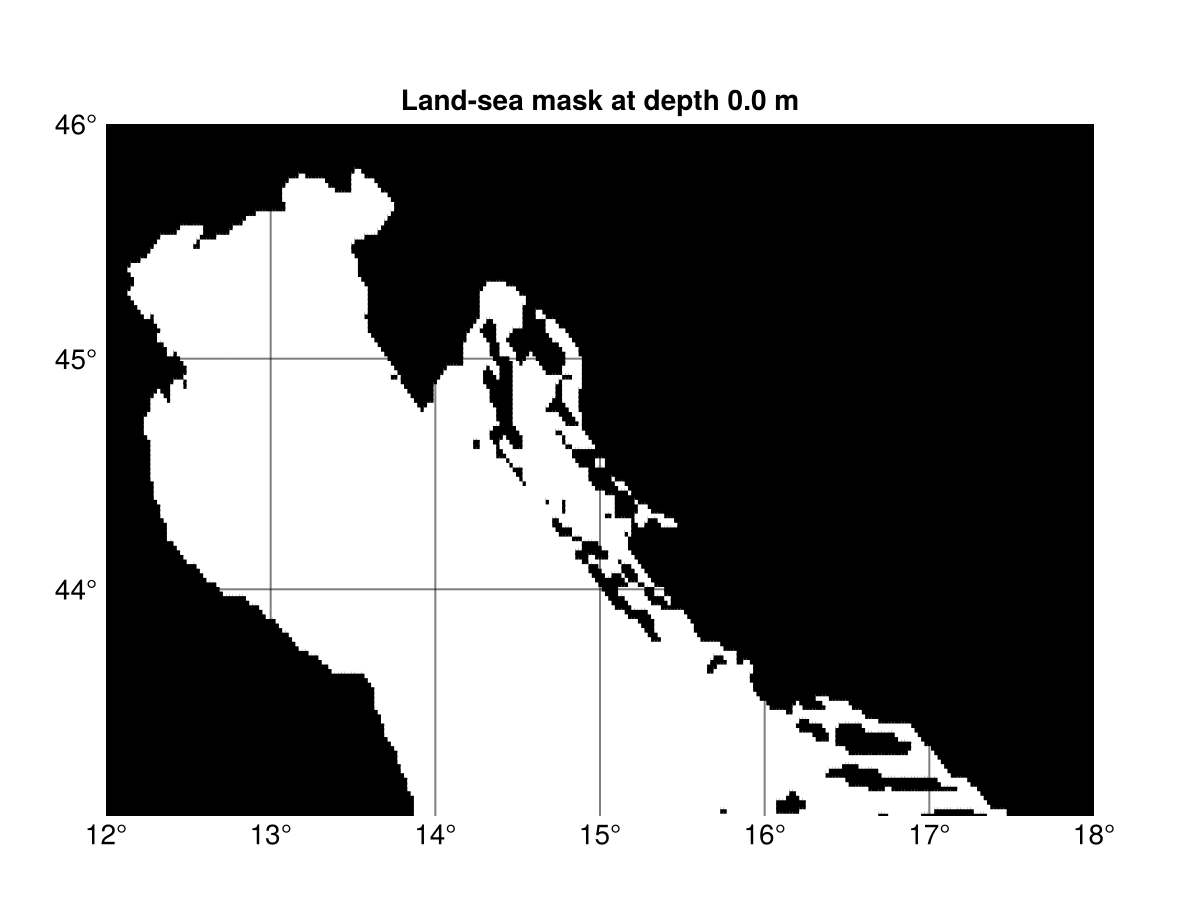

In [44]:
if doplot
    fig, ga = plot_mask(mask[:, :, 1], depthr[1])
    fig
end

#### Edit the land-sea mask
We want to get rid of the small, unconnected sea regions.      
The function `floodfill` allows one to assign an index to each sub-region. 

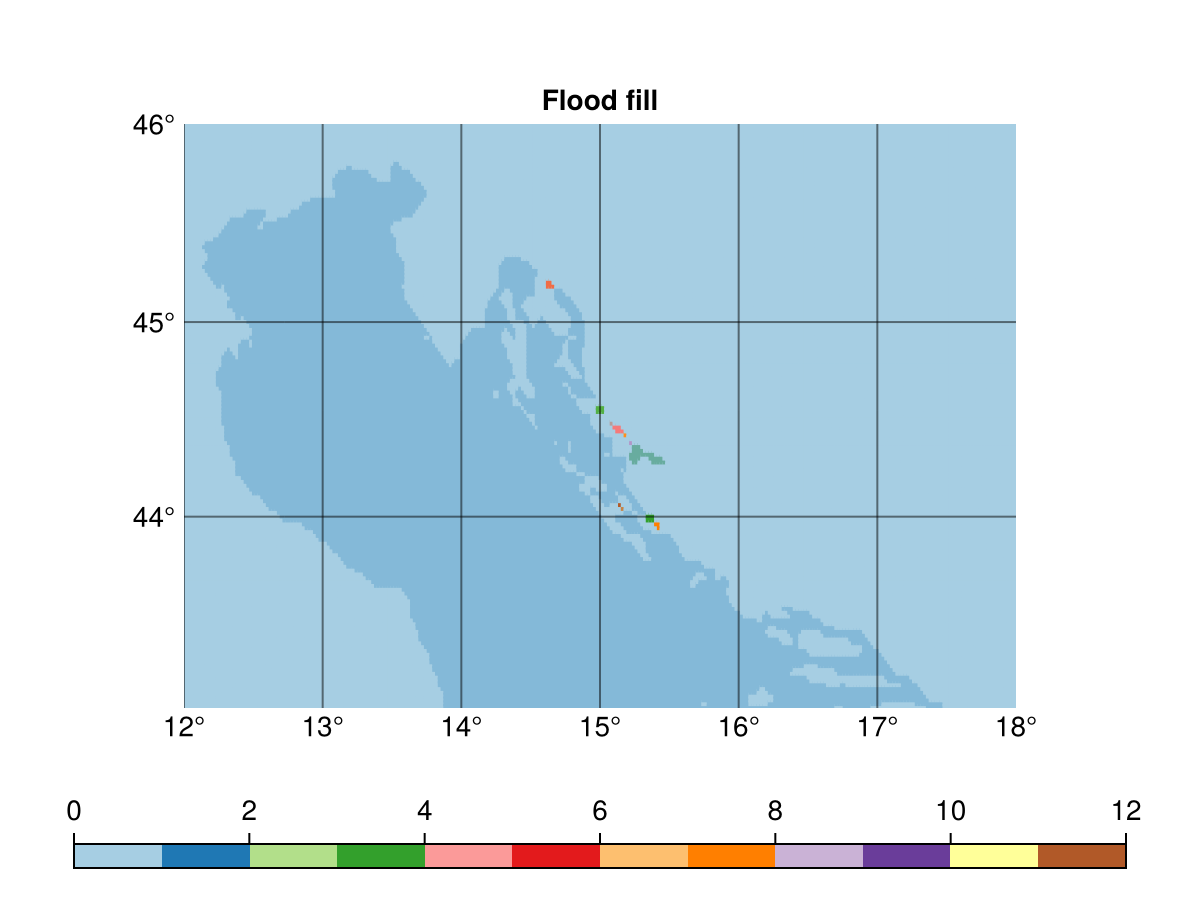

In [54]:
label = DIVAnd.floodfill(mask)

if doplot

    fig2 = Figure()
    ga2 = GeoAxis(fig2[1, 1]; dest = "+proj=merc", title = "Flood fill")
    hm2 = heatmap!(
        ga2,
        bx,
        by,
        label[:, :, 1],
        interpolate = false,
        colormap = cgrad(:Paired_12, length(unique(label)) - 1, categorical = true),
    )
    xlims!(ga2, (bx[1], bx[end]))
    ylims!(ga2, (by[1], by[end]))
    Colorbar(fig2[2, 1], hm2, vertical = false)
    fig2
end

We keep only the main water body, for which `label .== 1`.

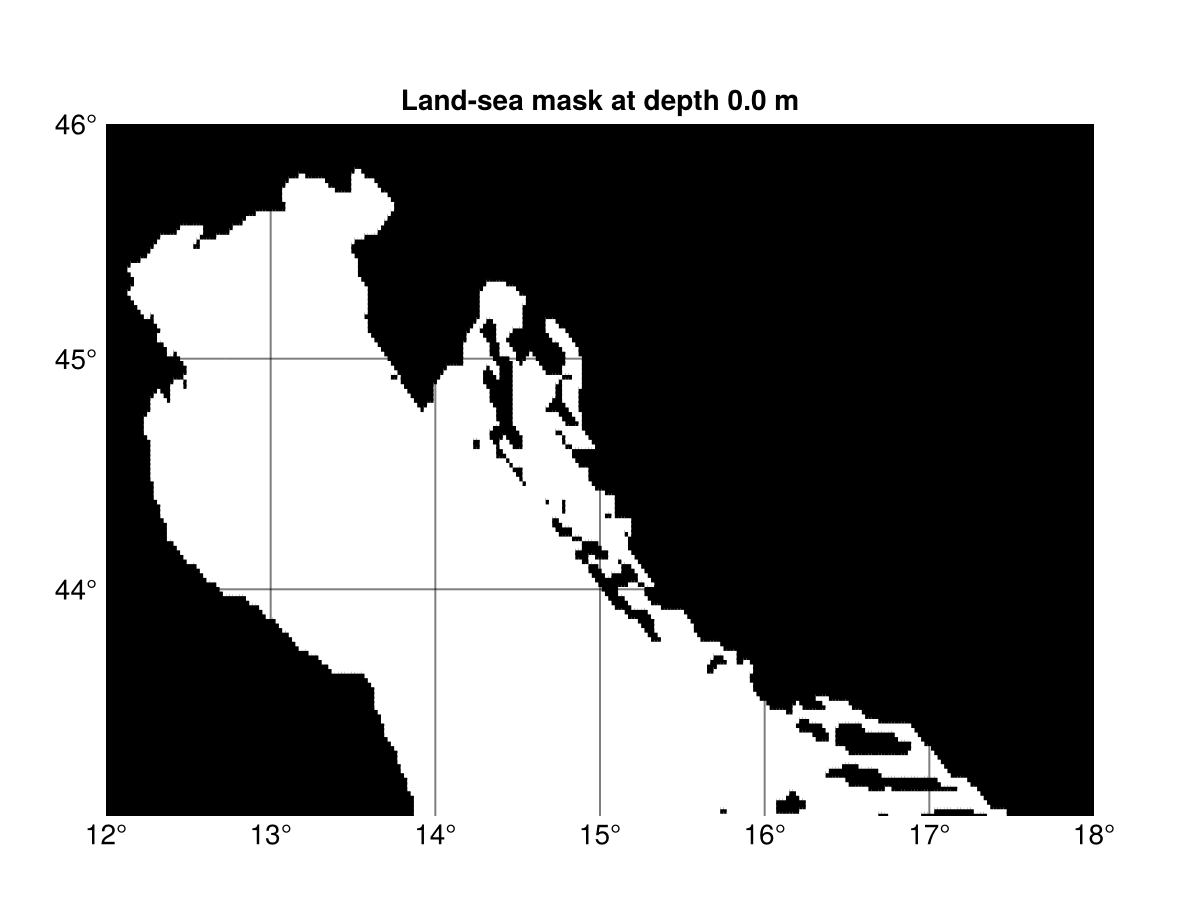

In [55]:
maskfilled = label .== 1
if doplot
    fig, ga = plot_mask(maskfilled[:, :, 1], depthr[1])
    fig
end

### 🗺️ Read the observations
We read the file (netCDF) obtained after the duplicate removal.       

<div class="alert alert-block alert-info">
Another possibility could be to directly use a file generated with `webODV`
</div>

In [57]:
obsval, obslon, obslat, obsdepth, obstime, obsid = loadobs(Float64, outputfile, varname);

#### 🗺️ Plot the observations

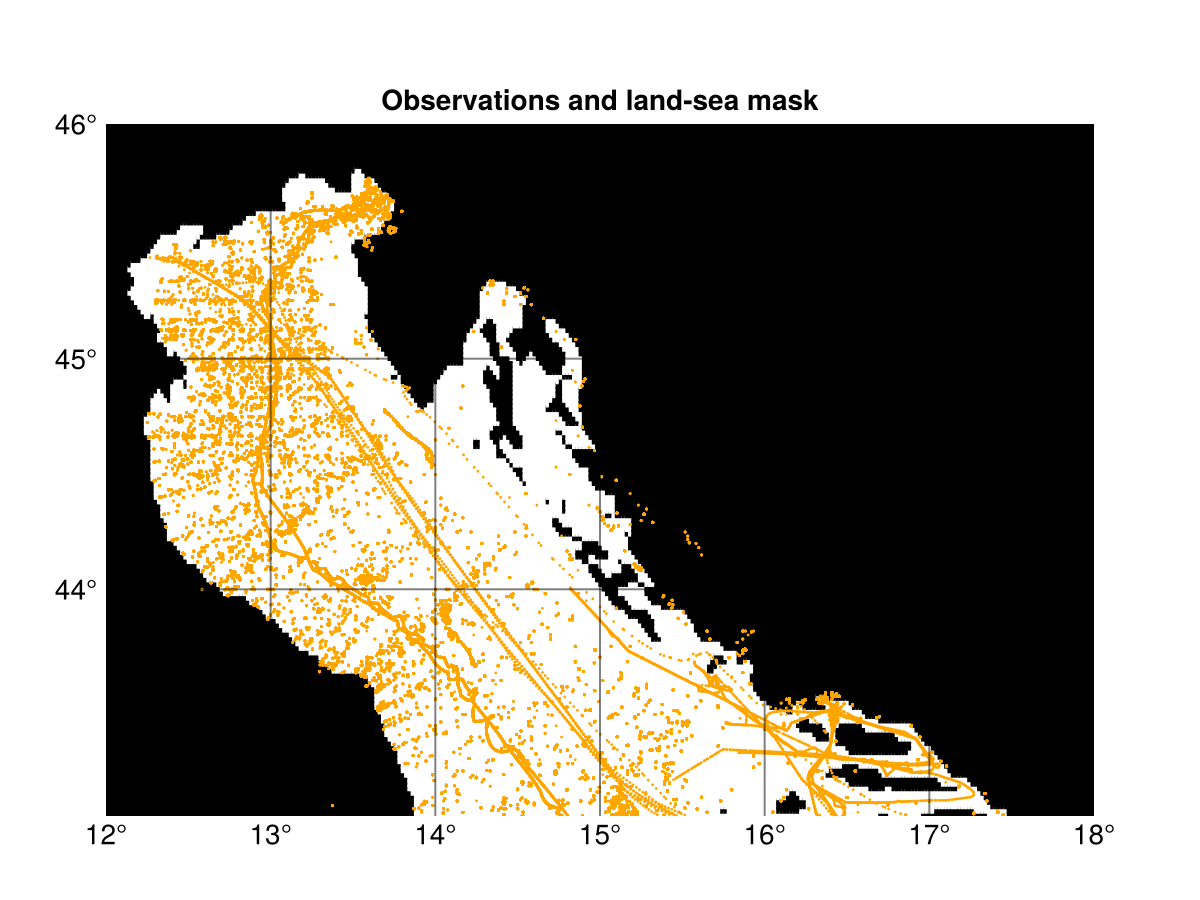

In [29]:
if doplot
    fig5, ga5 = plot_mask(maskfilled[:, :, 1], depthr[1])
    ga5.title = "Observations and land-sea mask"
    plot!(ga5, obslon, obslat, markersize = 2, color = :orange)
    fig5
end

### Parameter setting

In [74]:
begin
    sz = (length(lonr), length(latr), length(depthr))
    lenx = fill(100_000.0, sz)   # 100 km
    leny = fill(100_000.0, sz)   # 100 km
    lenz = fill(5.0, sz)      # 25 m 
    len = (lenx, leny, lenz)
    epsilon2 = 0.1

end

0.1

### Weight computation
In some situations, it is a good idea to decrease the data weight according to their proximity (in space and in time), so that very close observations don't influence too much the interpolation.
<div class="alert alert-block alert-warning">
This step can really be time consuming
</div>

In [75]:
# @time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
# @show maximum(rdiag), mean(rdiag)
# epsilon2 = epsilon2 * rdiag;

### Metadata

### Interpolation
This is where all the computation takes place.    
The results are written in the chosen `outputfileclim` (netCDF).

In [ ]:
outputfileclim = joinpath(outputdir, "$(regionname)_$(varname).nc")
isfile(outputfileclim) ? rm(outputfileclim) : @debug("ok")

@time dbinfo = diva3d(
    (lonr, latr, depthr, TS),
    (obslon, obslat, obsdepth, obstime),
    obsval,
    len,
    epsilon2,
    outputfileclim,
    varname,
    bathname = bathfile,
    mask = maskfilled,
    fitcorrlen = false,
    niter_e = 2,
    surfextend = true,
);

[ Info: Creating netCDF file ../output/North_Adriatic/North_Adriatic_sea_water_salinity.nc
[ Info: Time step 1 / 12
[ Info: scaled correlation length (min,max) in dimension 1: (100000.0, 100000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (100000.0, 100000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (5.0, 5.0)
┌ Warning: resolution (5.0) is too coarse for correlation length 5.0 in dimension 3 at indices CartesianIndex(95, 1, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 8
┌ Warning: resolution (5.0) is too coarse for correlation length 5.0 in dimension 3 at indices CartesianIndex(95, 1, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 8

## 🗺️ Plot the results
### Set the depth and the month of interest

In [ ]:
themonth = 6
thedepth = 30

In [ ]:
depthindex = findfirst(depthr .== thedepth)
ds = NCDataset(outputfileclim, "r")
field2plot = ds[varname][:, :, depthindex, themonth]
close(ds)

In [ ]:
fig = Figure()
ga = GeoAxis(
    fig[1, 1];
    dest = "+proj=merc",
    title = "$(varname) at $(thedepth) m in $(Dates.monthname(themonth))",
)
hm = heatmap!(ga, lonr, latr, field2plot, interpolate = false, colormap = Reverse(:RdYlBu))
xlims!(ga, (bx[1], bx[end]))
ylims!(ga, (by[1], by[end]))
Colorbar(fig[2, 1], hm, vertical = false, label = "°C")
fig

In [ ]:
fig5, ga5 = plot_mask(maskfilled[:, :, 5], depthr[5])
display(fig5)